In [1]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exr_file = OpenEXR.InputFile('renders/Bistro/900p/frame-2000.exr')

In [3]:
def get_image_dims(header):
    width = header['dataWindow'].max.x - header['dataWindow'].min.x + 1
    height = header['dataWindow'].max.y - header['dataWindow'].min.y + 1
    return width, height

In [4]:
exr_file.header()

{'BlenderMultiChannel': b'Blender V2.55.1 and newer',
 'Camera': b'Camera',
 'Date': b'2024/11/17 11:26:17',
 'File': b'/home/cosi/projects/orca-blender/scenes/Bistro/BistroExterior.blend',
 'Frame': b'2000',
 'RenderTime': b'01:22.77',
 'Scene': b'Scene',
 'Time': b'00:01:23:08',
 'channels': {'ViewLayer.Combined.A': FLOAT (1, 1),
  'ViewLayer.Combined.B': FLOAT (1, 1),
  'ViewLayer.Combined.G': FLOAT (1, 1),
  'ViewLayer.Combined.R': FLOAT (1, 1),
  'ViewLayer.DiffCol.B': FLOAT (1, 1),
  'ViewLayer.DiffCol.G': FLOAT (1, 1),
  'ViewLayer.DiffCol.R': FLOAT (1, 1),
  'ViewLayer.DiffDir.B': FLOAT (1, 1),
  'ViewLayer.DiffDir.G': FLOAT (1, 1),
  'ViewLayer.DiffDir.R': FLOAT (1, 1),
  'ViewLayer.DiffInd.B': FLOAT (1, 1),
  'ViewLayer.DiffInd.G': FLOAT (1, 1),
  'ViewLayer.DiffInd.R': FLOAT (1, 1),
  'ViewLayer.Emit.B': FLOAT (1, 1),
  'ViewLayer.Emit.G': FLOAT (1, 1),
  'ViewLayer.Emit.R': FLOAT (1, 1),
  'ViewLayer.Env.B': FLOAT (1, 1),
  'ViewLayer.Env.G': FLOAT (1, 1),
  'ViewLayer.Env.

In [5]:
width, height = get_image_dims(exr_file.header())

In [6]:
def load_layer(file, name):
    r = file.channel(f'ViewLayer.{name}.R')
    g = file.channel(f'ViewLayer.{name}.G')
    b = file.channel(f'ViewLayer.{name}.B')
    
    r_array = np.frombuffer(r, dtype=np.float32).reshape(height, width)
    g_array = np.frombuffer(g, dtype=np.float32).reshape(height, width)
    b_array = np.frombuffer(b, dtype=np.float32).reshape(height, width)

    return np.stack([r_array, g_array, b_array], axis=0)

In [7]:
combined = load_layer(exr_file, 'Combined')
gloss_col = load_layer(exr_file, 'GlossCol')
gloss_dir = load_layer(exr_file, 'GlossDir')
gloss_ind = load_layer(exr_file, 'GlossInd')
diff_col = load_layer(exr_file, 'DiffCol')
diff_dir = load_layer(exr_file, 'DiffDir')
diff_ind = load_layer(exr_file, 'DiffInd')
emit = load_layer(exr_file, 'Emit')
env = load_layer(exr_file, 'Env')

In [22]:
combined.shape

(3, 900, 1600)

In [22]:
irradiance = np.divide(gloss_dir, gloss_col, where=gloss_col != 0)

In [23]:
# Split result into R, G, B channels for EXR storage
irradiance_r = irradiance[:, :, 0].tobytes()
irradiance_g = irradiance[:, :, 1].tobytes()
irradiance_b = irradiance[:, :, 2].tobytes()

height, width = 900, 1600
header = OpenEXR.Header(width, height)

irradiance_layer_name = "ViewLayer.Irradiance"

header['channels'] = {
    f"{irradiance_layer_name}.B": Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT)),
    f"{irradiance_layer_name}.G": Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT)),
    f"{irradiance_layer_name}.R": Imath.Channel(Imath.PixelType(Imath.PixelType.FLOAT)),
}
output_exr = OpenEXR.OutputFile("irradiance.exr", header)
output_exr.writePixels({
    f"{irradiance_layer_name}.B": irradiance_b,
    f"{irradiance_layer_name}.G": irradiance_g,
    f"{irradiance_layer_name}.R": irradiance_r,
})
output_exr.close()

In [34]:
def tonemap(image, gamma=2.2):
    ldr = np.clip(image, 0, 65535)
    ldr = np.log(ldr + 1) ** (1 / gamma)
    return ldr

def hdr_clip(image, max_value=65535):
    return np.clip(image, 0, max_value)

def display_image(image):
    image = image.transpose(1, 2, 0)
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

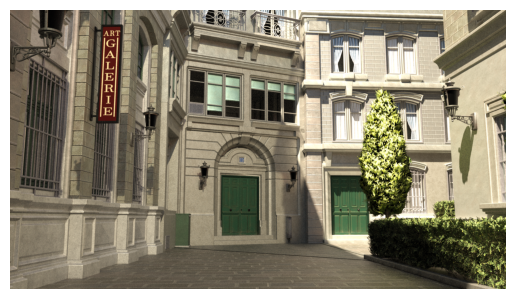

In [35]:
display_image(tonemap(hdr_clip(gloss_dir + gloss_ind) * gloss_col))

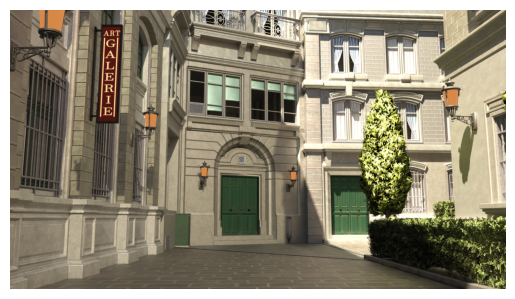

In [18]:
display_image(tonemap(combined))

In [24]:
exr_file = OpenEXR.InputFile('frame-0002.exr')
x = exr_file.channel('ViewLayer.Vector.X')
y = exr_file.channel('ViewLayer.Vector.Y')
z = exr_file.channel('ViewLayer.Vector.Z')
w = exr_file.channel('ViewLayer.Vector.W')

x_array = np.frombuffer(x, dtype=np.float32).reshape(270, 480)
y_array = np.frombuffer(y, dtype=np.float32).reshape(270, 480)
z_array = np.frombuffer(z, dtype=np.float32).reshape(270, 480)
w_array = np.frombuffer(w, dtype=np.float32).reshape(270, 480)

In [29]:
w_array[48, 135]

np.float32(-0.23907626)

['225p', '900p']
['combined', 'depth', 'diffuse-col', 'diffuse-dir', 'diffuse-ind', 'emission', 'environment', 'glossy-col', 'glossy-dir', 'glossy-ind', 'normal', 'roughness', 'vector']
0.0 0.8465407


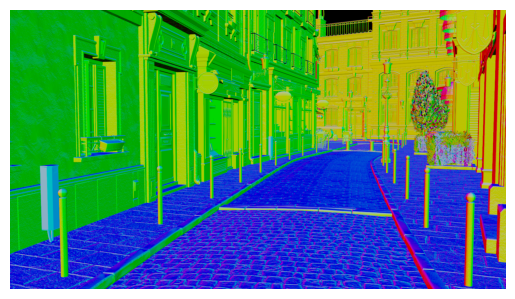

In [47]:
import h5py

with h5py.File('datasets/bistro.hdf5', 'r') as f:
    print(list(f.keys()))
    print(list(f['900p/test/seq-000/frame-000'].keys()))
    combined = f['900p/test/seq-000/frame-000/normal'][:]
    
display_image(combined[:3, :, :].transpose(1, 2, 0))